In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import integrate

In [2]:
def free_energy_from_file(temp, chi, N):
    path = os.path.join(f"{int(100*temp)}\\{chi}", f"{N}.npz")
    data = np.load(path)

    log_factors = np.array(data["log_factors"])
    n_spins = np.array(data["n_spins"])

    return -temp * np.sum(log_factors / n_spins)

In [3]:
def plot_free_energy_vs_steps(temp, chi):
    directory = f"{int(100*temp)}_{chi}"
    files = [f for f in os.listdir(directory) if f.endswith(".npz")]
    if not files:
        raise FileNotFoundError("No .npz files found for this TRG run.")
    files = sorted(files, key=lambda x: int(x.split(".")[0]))
    steps = []
    free_energies = []

    for fname in files:
        path = os.path.join(directory, fname)
        data = np.load(path)
        log_factors = np.array(data["log_factors"])
        n_spins = np.array(data["n_spins"])
        step = int(fname.split(".")[0])

        F = -temp * np.sum(log_factors / n_spins)

        steps.append(step)
        free_energies.append(F)

    plt.plot(steps, free_energies, marker="o",label=f'chi = {chi}')
    plt.xlabel("TRG step")
    plt.ylabel("Free Energy Per Site")
    plt.title(fr"Free Energy Per Site ($k_BT/\ J$ = {temp})")
    plt.tight_layout()

In [4]:
def kappa_from_K(K):
    return 2.0 * np.sinh(2.0 * K) / (np.cosh(2.0 * K)**2)


def _integrand(theta, kappa):
    s = np.sin(theta)
    inside_sqrt = 1.0 - (kappa**2) * (s**2)
    inside_sqrt = np.clip(inside_sqrt, 0.0, None)
    return np.log(0.5 * (1.0 + np.sqrt(inside_sqrt)))


def free_energy_per_site(T, J=1.0, k_B=1.0, **quad_kwargs):
   
    beta = 1.0 / (k_B * T)
    K = beta * J
    kap = kappa_from_K(K)
    I, err = integrate.quad(_integrand, 0.0, np.pi, args=(kap,), **quad_kwargs)
    minus_beta_f = np.log(2.0 * np.cosh(2.0 * K)) + (1.0 / (2.0 * np.pi)) * I
    f = -minus_beta_f / beta
    return f

In [5]:
F = free_energy_per_site(2.27)

In [6]:
F

np.float64(-2.1099014587868656)

In [7]:
def plot_free_energy_deviation(temp, chi, F_theory):
    directory = f"{int(100*temp)}_{chi}"
    files = [f for f in os.listdir(directory) if f.endswith(".npz")]
    if not files:
        raise FileNotFoundError("No .npz files found for this TRG run.")
    files = sorted(files, key=lambda x: int(x.split(".")[0]))

    steps = []
    deviations = []

    for fname in files:
        path = os.path.join(directory, fname)
        data = np.load(path)
        log_factors = np.array(data["log_factors"])
        n_spins = np.array(data["n_spins"])
        step = int(fname.split(".")[0])

        F_trg = -temp * np.sum(log_factors / n_spins)

        steps.append(step)
        deviations.append(abs(F_trg - F_theory))
    plt.plot(steps, deviations, marker="o", label = f'chi = {chi}')
    plt.xlabel("TRG Step")
    plt.ylabel(r"Relative Error $\varepsilon_r$")
    plt.title(f"Error of Free Energy Per Site (T/J = {temp})")
    plt.tight_layout()

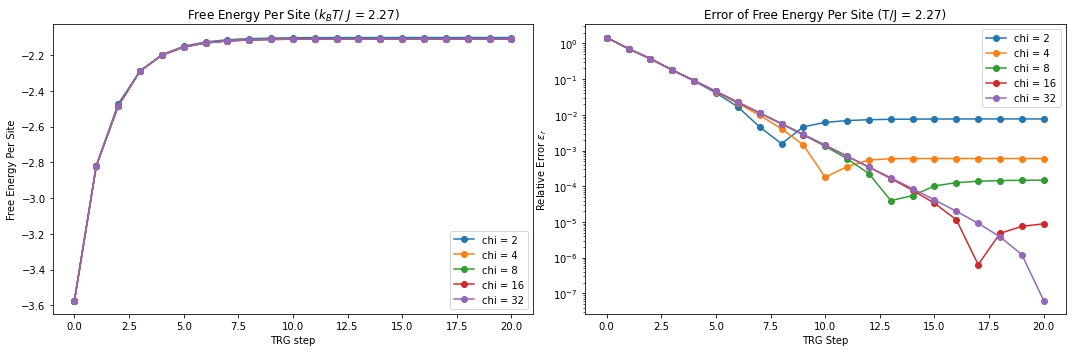

In [8]:
plt.figure(figsize=(15, 5))
N = [2,4,8,16,32]
for n in N:
    plt.subplot(121)
    plot_free_energy_vs_steps(2.27, n)
    plt.subplot(122)
    plot_free_energy_deviation(2.27, n, F)
plt.subplot(121)
plt.legend()
plt.subplot(122)
plt.legend()
plt.yscale('log')